Implementation of Seqential recommendation system by Suraj And Albin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandarallel
# Importing the required library for the task
import pandas as pd
import numpy as np
import scipy.stats
import itertools


from pandarallel import pandarallel

#mounting the the google drive

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# naming of required column for all data
columns_name = {'data' : ["user_id", "item_id", "rating", "timestamp"] ,
                'item' : ['movie_id', 'movie_title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown' , 'Action', 'Adventure' , 'Animation' ,
              'Children', 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western' ],
              'user': ['user_id' , 'age' , 'gender' , 'occupation' , 'zip code'],
              'genre' : ['genre_name', 'genre_ID'] 
              }

In [ ]:
#reading data from the file of google drive
data = pd.read_csv('/content/drive/MyDrive/recommenderassignment1/u.data', "\t", encoding="utf-8", names= columns_name['data'])
print(data.head(5))
print("---------------------------------------------")
print("Number of row of the given data is: ", len(data.user_id))
print("---------------------------------------------")
print(data.info())
print("---------------------------------------------")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
---------------------------------------------
Number of row of the given data is:  100000
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None
---------------------------------------------


In [ ]:
# reading movies file from the drive
movies = pd.read_csv("/content/drive/MyDrive/recommenderassignment1/u.item", sep = '|' ,encoding="latin-1", names= columns_name['item'])
print('----------------------------------------------------')
print(movies.head(2))
print("----------------------------------------------------")
print("Total number of given movies is : ",len(movies))
print("----------------------------------------------------")
movies.drop(['video_release_date', 'release_date', 'IMDb_URL'], axis=1, inplace = True)
print(movies.head(2))
print("----------------------------------------------------")
movies=movies[0:100]

----------------------------------------------------
   movie_id       movie_title release_date  video_release_date  \
0         1  Toy Story (1995)  01-Jan-1995                 NaN   
1         2  GoldenEye (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   

   Adventure  Animation  Children  ...  Fantasy  Film_Noir  Horror  Musical  \
0          0          1         1  ...        0          0       0        0   
1          1          0         0  ...        0          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0       0         0    0        0  
1        0        0       0         1    0        0  

[2 rows x 24 columns]
----------------------------------------------------
Total number of given movies is :  1682
------------

In [ ]:
#reading user file from the drive
user = pd.read_csv('/content/drive/MyDrive/recommenderassignment1/u.user', sep = "|", encoding="utf-8", names= columns_name['user'])
print(user.head(2))
print("----------------------------------------------------")
print(len(user.user_id))
print("----------------------------------------------------")
genre = pd.read_csv('/content/drive/MyDrive/recommenderassignment1/u.genre', "|", encoding="utf-8", names= columns_name['genre'])
print(genre.head(2))

   user_id  age gender  occupation zip code
0        1   24      M  technician    85711
1        2   53      F       other    94043
----------------------------------------------------
943
----------------------------------------------------


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


  genre_name  genre_ID
0    unknown         0
1     Action         1


In [ ]:
def correlation_pearson(usera,userb):
  #step 1get all ratings by 2 users
  usera_ratings = data[data['user_id'] == usera].sort_values(by=['item_id'])
  userb_ratings = data[data['user_id'] == userb].sort_values(by=['item_id'])
  #step 2 get movie id watched by both users dubai le hereko movie ko dataframe
  userab = usera_ratings[usera_ratings["item_id"].isin(userb_ratings["item_id"])].sort_values(by=['item_id'])
  userba = userb_ratings[userb_ratings["item_id"].isin(usera_ratings["item_id"])].sort_values(by=['item_id'])
  #mean
  usera_mean = np.mean(usera_ratings['rating'])
  userb_mean = np.mean(userb_ratings['rating'])
  #Subtract
  var_a = np.array(np.subtract(userab['rating'],[usera_mean]))
  var_b = np.array(np.subtract(userba['rating'],[userb_mean]))
  #correlation formula
  first =np.sum(var_a*var_b)
  second =np.sqrt(np.sum(np.power(var_a,2)))*np.sqrt(np.sum(np.power(var_b,2)))
  correlation = first/second
  return correlation,usera,userb

In [ ]:
#top_ten users
def top_users(userid,num_of_users):
  test_users = user[user["user_id"] != userid]
  correlations_of_users = test_users.apply(lambda user:correlation_pearson(userid,user['user_id']), axis=1, result_type='expand')
  correlations_of_users.columns=['correlation','usera','userb']
  correlations_of_users = correlations_of_users.sort_values(by=['correlation'], ascending=False)
  similar_user = correlations_of_users.head(num_of_users)
  return similar_user

In [ ]:
#Calculate the item score for a user based on another user
def item_score_userab(usera,userb,item_id):
  #get user rating for an item
  usera_ratings = data[data['user_id'] == usera].sort_values(by=['item_id'])
  userb_ratings = data[data['user_id'] == userb].sort_values(by=['item_id'])
  #step 2 get movie id watched by both users dubai le hereko movie ko dataframe
  userba = userb_ratings[userb_ratings["item_id"].isin(usera_ratings["item_id"])].sort_values(by=['item_id'])
  #mean of user b
  userb_mean = np.mean(usera_ratings['rating'])
  #pearson correlation 
  correlation, usera ,userb =correlation_pearson(usera,userb)
  var_b = float(userb_ratings[userb_ratings["item_id"] == item_id]["rating"]) - userb_mean
  #output
  first = correlation *var_b
  second = correlation
  return [first,second]

In [ ]:
def user_movie_predict(user_id,item_id):
  #user ratings
   user_ratings = data[data['user_id'] == user_id].sort_values(by=['item_id'])
   #get mean user ratings
   user_ratings_mean= np.mean(user_ratings['rating'])
   #get other user who have rated the movie
   other_users = data[data['item_id'] ==item_id]
   #calculate item score
   score = other_users.apply(lambda user:item_score_userab(user_id,user['user_id'],item_id),axis=1, result_type='expand' )
   score= np.array(score)
   score = score[~np.isnan(score).any(axis=1), :]
   prediction_score = user_ratings_mean + np.sum(score[:,0]) / np.sum(score[:,1])

   return item_id, movies.at[item_id - 1, 'movie_title'], prediction_score

In [ ]:
def get_user_prediction(user_id):
  pandarallel.initialize(nb_workers=64,progress_bar=True)


  movies_score=movies.parallel_apply(lambda movie:user_movie_predict(user_id,movie['movie_id']),axis=1,result_type="expand")

  movies_score.columns = ['movie_id',"movie_title","prediction_rating"]


  return movies_score

In [ ]:
  usera_ratings = get_user_prediction(2)
  userb_ratings = get_user_prediction(5)
  userc_ratings = get_user_prediction(6)

  print(usera_ratings.head(10))
  
  print(userb_ratings.head(10))
  
  print(userc_ratings.head(10))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


   movie_id                                        movie_title  \
0         1                                   Toy Story (1995)   
1         2                                   GoldenEye (1995)   
2         3                                  Four Rooms (1995)   
3         4                                  Get Shorty (1995)   
4         5                                     Copycat (1995)   
5         6  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
6         7                              Twelve Monkeys (1995)   
7         8                                        Babe (1995)   
8         9                            Dead Man Walking (1995)   
9        10                                 Richard III (1995)   

   prediction_rating  
0           3.900488  
1           3.090040  
2           2.941847  
3           3.560748  
4           3.216972  
5           3.881714  
6           3.824165  
7           3.947538  
8           4.018546  
9           3.207726  
   movie_id         

**Average Aggregation method**

In [ ]:
def agg_method(usera,userb,userc):

  group_data = [usera_ratings["movie_title"],usera_ratings["prediction_rating"],userb_ratings["prediction_rating"],userc_ratings["prediction_rating"]]
  headers = ["movie title", "usera rating", "userb rating", "userc rating"]
  users_ratings_combine_agg = pd.concat(group_data,axis=1,keys=headers)
  users_ratings_combine_agg['average_aggregration'] =  users_ratings_combine_agg.iloc[:,1:4].mean(axis=1)

  return users_ratings_combine_agg

In [ ]:
def get_average_top_movies(usera,userb,userc,num_of_movies):

  users_ratings_combine = agg_method(usera,userb,userc)
  print(users_ratings_combine)
  popular_movies = users_ratings_combine.sort_values(by=["average_aggregration"],ascending=False)
  
  
  return popular_movies

In [ ]:
movie_avg_met = agg_method(2,4,6)
movie_avg_met.head(20)

,movie title,usera rating,userb rating,userc rating,average_aggregration
0,Toy Story (1995),3.900488,3.981130,3.850876,3.910832
1,GoldenEye (1995),3.090040,3.183859,3.039453,3.104451
2,Four Rooms (1995),2.941847,2.902119,3.071217,2.971728
3,Get Shorty (1995),3.560748,3.625485,3.665220,3.617151
4,Copycat (1995),3.216972,3.194578,3.293438,3.234996
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,3.881714,3.804613,3.832767,3.839698
6,Twelve Monkeys (1995),3.824165,3.842728,3.674140,3.780344
7,Babe (1995),3.947538,3.936636,4.011985,3.965386
8,Dead Man Walking (1995),4.018546,3.779411,4.115668,3.971209
9,Richard III (1995),3.207726,3.366487,4.000655,3.524956


**Task 2: Least-misery aggregation method**

df.plot(kind="box")

**Taking the prediction value of each user according to the quantile range from 0.05 to 0.95 and taking the combined dataframe according to the movie id for selected user**

(98, 6)


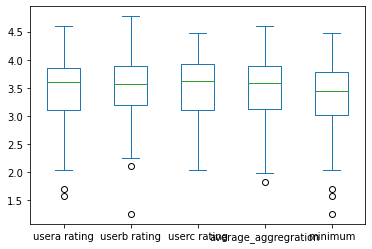

In [ ]:
df1 = df[(df["userc rating"]>=1) & (df["userc rating"] <=5) & (df["usera rating"] >=1) & (df["usera rating"]<=5) & (df["userb rating"] >=1) & (df["userb rating"]<=5)]
print(df1.shape)
df1.plot(kind='box')

**Spliting the df into 5 df**

In [ ]:
chunkdf = np.array_split(df1,5)

In [ ]:
chunkdf[0]

,movie title,usera rating,userb rating,userc rating,average_aggregration,minimum
0,Toy Story (1995),3.900488,3.981130,3.850876,3.910832,3.850876
1,GoldenEye (1995),3.090040,3.183859,3.039453,3.104451,3.039453
2,Four Rooms (1995),2.941847,2.902119,3.071217,2.971728,2.902119
3,Get Shorty (1995),3.560748,3.625485,3.665220,3.617151,3.560748
4,Copycat (1995),3.216972,3.194578,3.293438,3.234996,3.194578
5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,3.881714,3.804613,3.832767,3.839698,3.804613
6,Twelve Monkeys (1995),3.824165,3.842728,3.674140,3.780344,3.674140
7,Babe (1995),3.947538,3.936636,4.011985,3.965386,3.936636
8,Dead Man Walking (1995),4.018546,3.779411,4.115668,3.971209,3.779411
9,Richard III (1995),3.207726,3.366487,4.000655,3.524956,3.207726


**Calculating satisfaction of each user for every chunks data**
- let us assume for our process the group list is the result produce from avg aggregation method.

In [ ]:
iterationsat_usera = []
iterationsat_userb = []
iterationsat_userc = []
iter_sat_abc = []
for i in range(5):
  userlistsata = chunkdf[i]["usera rating"].sum()
  userlistsatb = chunkdf[i]["userb rating"].sum()
  userlistsatc = chunkdf[i]["userc rating"].sum()
  grplistsat = chunkdf[i]["average_aggregration"].sum()
  sata = grplistsat/userlistsata
  satb = grplistsat/userlistsatb
  satc = grplistsat/userlistsatc
  iterationsat_usera.append(sata)
  iterationsat_userb.append(satb)
  iterationsat_userc.append(satc)
  iter_sat_abc.append([sata, satb, satc])


In [ ]:
print(iterationsat_usera)
print(iterationsat_userb)
print(iterationsat_userc)

[1.0082925045126263, 1.0004586996335172, 1.0107323151038192, 0.991859280176713, 0.9996722657977064]
[1.0129030169599864, 0.9885554629851365, 0.995086365498497, 0.9919355551326189, 0.9926057134625157]
[0.9794674681535601, 1.0112435533614912, 0.9943516273032501, 1.016608892452717, 1.0078381700579393]


In [ ]:
print(iter_sat_abc)

[[1.0082925045126263, 1.0129030169599864, 0.9794674681535601], [1.0004586996335172, 0.9885554629851365, 1.0112435533614912], [1.0107323151038192, 0.995086365498497, 0.9943516273032501], [0.991859280176713, 0.9919355551326189, 1.016608892452717], [0.9996722657977064, 0.9926057134625157, 1.0078381700579393]]


**Calculating overall satisfaction of the user**

In [ ]:
sato_a = sum(iterationsat_usera)/len(iterationsat_usera)
sato_b = sum(iterationsat_userb)/len(iterationsat_userb)
sato_c = sum(iterationsat_userc)/len(iterationsat_userc)
print(sato_a, sato_b, sato_c)

1.0022030130448765 0.9962172228077509 1.0019019422657915


**Calculation of alpha value**

In [ ]:
alpha = [0] # Initiating the alpha with value 0 because for the first iteration the value of alpha is zero.
for i in range(4):
  maxsat = max(iter_sat_abc[i+1])
  minsat = min(iter_sat_abc[i+1])
  a = maxsat - minsat
  alpha.append(a)

In [ ]:
print(alpha)

[0, 0.022688090376354664, 0.016380687800569116, 0.02474961227600403, 0.015232456595423605]


**Use of alpha in sequential hybrid aggregation Method**

In [ ]:
for i in range(5):
  chunkdf[i]["sequential_score"] = (1-alpha[i])*chunkdf[i]["average_aggregration"] + alpha[i]*chunkdf[i]["minimum"]

**20 top movie recommendation according to Sequential Hybrid aggregation method**

In [ ]:
recommended_movies_chunk = []
for i in range(5):
  topmovie_recommendation = chunkdf[i].sort_values("sequential_score", ascending = False, ignore_index=True).head(20)
  display(topmovie_recommendation)
  recommended_movies_chunk.append(topmovie_recommendation)

,movie title,usera rating,userb rating,userc rating,average_aggregration,minimum,sequential_score
0,"Usual Suspects, The (1995)",4.446519,4.511684,4.417010,4.458404,4.417010,4.458404
1,"Postino, Il (1994)",4.052797,3.712693,4.249369,4.004953,3.712693,4.004953
2,Dead Man Walking (1995),4.018546,3.779411,4.115668,3.971209,3.779411,3.971209
3,Babe (1995),3.947538,3.936636,4.011985,3.965386,3.936636,3.965386
4,Toy Story (1995),3.900488,3.981130,3.850876,3.910832,3.850876,3.910832
5,Antonia's Line (1995),3.783061,3.887833,3.989572,3.886822,3.783061,3.886822
6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,3.881714,3.804613,3.832767,3.839698,3.804613,3.839698
7,Seven (Se7en) (1995),3.796313,3.862344,3.746462,3.801707,3.746462,3.801707
8,Twelve Monkeys (1995),3.824165,3.842728,3.674140,3.780344,3.674140,3.780344
9,Get Shorty (1995),3.560748,3.625485,3.665220,3.617151,3.560748,3.617151


,movie title,usera rating,userb rating,userc rating,average_aggregration,minimum,sequential_score
0,Taxi Driver (1976),4.212438,4.068320,4.293954,4.191571,4.068320,4.188774
1,Braveheart (1995),4.139410,4.138254,3.920890,4.066184,3.920890,4.062888
2,Belle de jour (1967),3.661514,4.022674,3.934560,3.872916,3.661514,3.868120
3,Apollo 13 (1995),3.908753,3.921722,3.673212,3.834563,3.673212,3.830902
4,Crumb (1994),3.663423,3.763167,3.882443,3.769677,3.663423,3.767267
5,Crimson Tide (1995),3.592571,3.770965,3.511831,3.625122,3.511831,3.622552
6,Rumble in the Bronx (1995),3.476913,3.546775,3.530503,3.518063,3.476913,3.517130
7,"Brothers McMullen, The (1995)",3.431618,3.471255,3.601276,3.501383,3.431618,3.499800
8,"Birdcage, The (1996)",3.601376,3.359164,3.352525,3.437688,3.352525,3.435756
9,Desperado (1995),3.455771,3.460941,3.241466,3.386059,3.241466,3.382779


,movie title,usera rating,userb rating,userc rating,average_aggregration,minimum,sequential_score
0,Star Wars (1977),4.609644,4.774320,4.439138,4.607701,4.439138,4.604939
1,Eat Drink Man Woman (1994),4.164948,4.361659,4.144836,4.223814,4.144836,4.222521
2,Hoop Dreams (1994),4.116555,4.192327,4.207950,4.172277,4.116555,4.171365
3,Pulp Fiction (1994),4.093374,4.094399,4.245217,4.144330,4.093374,4.143495
4,Three Colors: Blue (1993),4.154768,4.032781,4.207510,4.131686,4.032781,4.130066
5,Three Colors: Red (1994),4.133487,4.032555,4.212864,4.126302,4.032555,4.124766
6,Priest (1994),3.860639,3.995706,4.195198,4.017181,3.860639,4.014617
7,Three Colors: White (1994),3.827472,3.862842,3.984415,3.891576,3.827472,3.890526
8,Clerks (1994),3.712465,4.080942,3.814290,3.869232,3.712465,3.866664
9,"Madness of King George, The (1994)",3.794636,3.876286,3.826960,3.832627,3.794636,3.832005


,movie title,usera rating,userb rating,userc rating,average_aggregration,minimum,sequential_score
0,"Shawshank Redemption, The (1994)",4.452792,4.463767,4.439387,4.451982,4.439387,4.451670
1,"Fugitive, The (1993)",4.072672,4.092084,3.940098,4.034951,3.940098,4.032604
2,Forrest Gump (1994),3.846700,3.614287,3.681814,3.714267,3.614287,3.711793
3,Four Weddings and a Funeral (1994),3.622047,3.757161,3.632097,3.670435,3.622047,3.669237
4,"Hudsucker Proxy, The (1994)",3.509908,3.595295,3.890220,3.665141,3.509908,3.661299
5,"Lion King, The (1994)",3.670968,3.614329,3.482676,3.589324,3.482676,3.586685
6,What's Eating Gilbert Grape (1993),3.570036,3.283414,3.571681,3.475044,3.283414,3.470301
7,Carlito's Way (1993),3.474751,3.503522,3.296554,3.424942,3.296554,3.421765
8,"Crow, The (1994)",3.405466,3.460372,3.227389,3.364409,3.227389,3.361018
9,Maverick (1994),3.309833,3.431648,3.105915,3.282465,3.105915,3.278096


,movie title,usera rating,userb rating,userc rating,average_aggregration,minimum,sequential_score
0,Fargo (1996),4.596102,4.506249,4.475524,4.525959,4.475524,4.525190
1,"Silence of the Lambs, The (1991)",4.318462,4.261592,4.473143,4.351066,4.261592,4.349703
2,Blade Runner (1982),4.135199,4.312306,4.253419,4.233641,4.135199,4.232142
3,Much Ado About Nothing (1993),4.108987,3.990320,3.994150,4.031152,3.990320,4.030530
4,"Remains of the Day, The (1993)",4.079423,4.046995,3.902745,4.009721,3.902745,4.008091
5,Searching for Bobby Fischer (1993),3.870970,3.979468,3.895287,3.915241,3.870970,3.914567
6,Terminator 2: Judgment Day (1991),3.863171,4.072042,3.802151,3.912455,3.802151,3.910774
7,Welcome to the Dollhouse (1995),3.946802,3.579941,3.985197,3.837313,3.579941,3.833393
8,Snow White and the Seven Dwarfs (1937),3.722985,3.603894,3.978910,3.768596,3.603894,3.766088
9,True Romance (1993),3.746381,3.706073,3.757579,3.736677,3.706073,3.736211


**Plot graph**

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

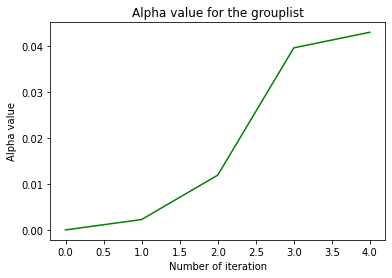

In [ ]:
ax = sns.lineplot(x = range(5), y=alpha, color="green")
ax.set(xlabel='Number of iteration', ylabel='Alpha value', title="Alpha value for the grouplist")
plt.show()

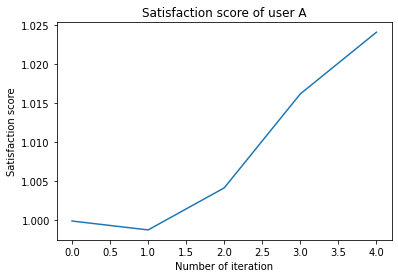

In [ ]:
ax = sns.lineplot(x=range(5), y = iterationsat_usera)
ax.set(xlabel='Number of iteration', ylabel='Satisfaction score', title="Satisfaction score of user A")
plt.show()

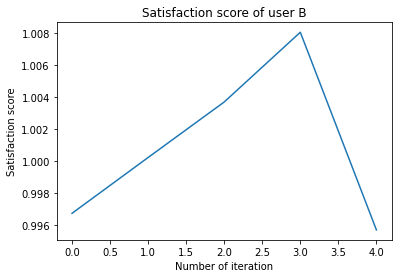

In [ ]:
ax = sns.lineplot(x=range(5), y = iterationsat_userb)
ax.set(xlabel='Number of iteration', ylabel='Satisfaction score', title="Satisfaction score of user B")
plt.show()

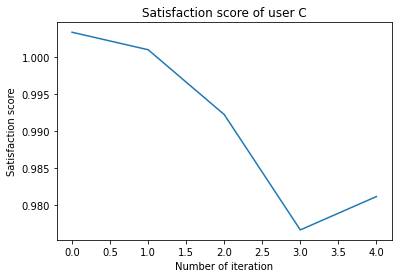

In [ ]:
ax = sns.lineplot(x=range(5), y = iterationsat_userc)
ax.set(xlabel='Number of iteration', ylabel='Satisfaction score', title="Satisfaction score of user C")
plt.show()

**Limitation And explanation**

Starting the value of alpha from zero for every other iteration we got the value of alpha relatively small. This could be because of our choice for the group of user is highly similar or the number of iteration is low. 

Because of small value of alpha it take the majority from the average aggregration model and minority from least misery aggregration model therefore representing as alike the distribution as average aggregration method but with slight lower value.

**Conclusion**

Our results shows that change (i.e. increasing and decreasing) in satisfaction level for each user.It also shows slight increase in alpha value in each iteration. From this we can say that the method used for the analysis is taking user preference over the movie choice by every iteration, and thus overcoming the limitation of average aggregation method and least misery aggregation method.